In [1]:
import torch
import torch.nn as nn
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import ast #used to parse list string
import torch.nn.functional as F

## Defining model classes 

# Current model tested

In [2]:
class TPMLPmodel(nn.Module):
    def __init__(self, input_size=2560, common_dim=1024, dropout_rate=0.2):
        super(TPMLPmodel, self).__init__()

        self.fc1 = nn.Linear(input_size, int(common_dim))
        self.bn1 = nn.BatchNorm1d(common_dim)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(common_dim, int(common_dim // 2))
        self.bn2 = nn.BatchNorm1d(int(common_dim // 2))
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(int(common_dim // 2), int(common_dim // 4))
        self.bn3 = nn.BatchNorm1d(int(common_dim // 4))
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(int(common_dim // 4), 1)

    def forward(self, x):
        x = self.dropout1(self.bn1(self.fc1(x)))
        x = F.gelu(x)

        x = self.dropout2(self.bn2(self.fc2(x)))
        x = F.gelu(x)


        x = self.dropout3(self.bn3(self.fc3(x)))
        x = F.gelu(x)

        x = self.fc4(x)
        x = torch.sigmoid(x).squeeze(1)

        return x

#  loading model

In [3]:
#this model is for the projection from protein dimension to molecule dimension
model1 = TPMLPmodel(
        input_size=1536, common_dim=512, dropout_rate=0.2
)
model1.load_state_dict(torch.load("./weights/weights.pth", map_location='cpu'))
model1.eval() #call the eval function



TPMLPmodel(
  (fc1): Linear(in_features=1536, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

#  Loading in test data

In [4]:
#loading in testing data 
df_test= pd.read_csv('./dataset/final_testing.csv')
print("data size: ", df_test.shape)
df_test.head()

data size:  (26282, 4)


,Unnamed: 0,Sequence,output,ankh_large
0,0,MRAAYACDPMATRGRAVVEEESAHRSPFQRDRDRIIHSSAFRRLKH...,0,"[0.017813269048929214, -0.008698908612132072, ..."
1,1,MDQNEANIYNENNENNENNENENCQNEPIRIKIII,0,"[0.019312381744384766, -0.00040120971971191466..."
2,2,MMDLIISTILLSLFIHFFDKFAKKRTIDGAYRIYVSVSNNKDLKKN...,0,"[0.015705883502960205, 0.004748153034597635, 1..."
3,3,MDKNTILEFCFFGDRYQLMALKNPNKLVKNKQVKAAFNVFMKHRTT...,0,"[0.024179138243198395, -0.0027669293340295553,..."
4,4,MSYYRSYYGGLGYGYGGFGGWGYGYGCGYGSFRRLGYGCGYGGYGF...,0,"[0.020798031240701675, -0.0033479060512036085,..."


In [5]:
#converting esm2 embeddings
protein_key = "ankh_large"#choose the key for the protein embedding. Currently available: esm2_t36_3B_UR50D (size 2560), esm2_t33_650M_UR50D (size 1280)
df_test[protein_key] = df_test[protein_key].apply(ast.literal_eval)
#converting chemberta embeddings
#function to convert column of python lists to a valid numpy array
def column_lists_to_numpy(column):
    final_list = []
    for list in column:
        final_list.append(list)
    final_list = np.array(final_list)
    return final_list

X_test_prot = column_lists_to_numpy(df_test[protein_key])
Y_test = np.array(df_test["output"])

print("x testing protein embedding shape:", X_test_prot.shape)
print("y testing shape:", Y_test.shape)

X_prot_test_tensor = torch.from_numpy(X_test_prot).float() 


x testing protein embedding shape: (26282, 1536)
y testing shape: (26282,)


## getting predicted values

In [6]:
with torch.no_grad():
    test_pred = model1(X_prot_test_tensor) #input torch tensors  
#convert predicted tensor to numpy
test_pred =  np.array(test_pred)

In [7]:
#set ideal cutoff based on model outputs in training code
ideal_cutoff = 0.6938000000000001

In [8]:

test_classified = (test_pred > ideal_cutoff).astype(int)
# Calculate evaluation metrics using this final cutoff
report = classification_report(Y_test, test_classified)
print(f'Test Classification Report:\n{report}')

print('Test Accuracy:,', accuracy_score(Y_test, test_classified))
print('Test Precision:,', metrics.precision_score(Y_test, test_classified)) #ability to classify negatives  
print('Test recall:,', metrics.recall_score(Y_test, test_classified)) #ability to classify positives  
print('Test f1:,', metrics.f1_score(Y_test, test_classified)) #ability to classify positives  
print("Test roc_auc_score:", metrics.roc_auc_score(Y_test, test_classified))
print("Test matthews_corrcoef(MCC):", metrics.matthews_corrcoef(Y_test, test_classified))



Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     18666
           1       0.88      0.70      0.78      7616

    accuracy                           0.89     26282
   macro avg       0.89      0.83      0.85     26282
weighted avg       0.89      0.89      0.88     26282

Test Accuracy:, 0.8871851457271136
Test Precision:, 0.8843166418773757
Test recall:, 0.7025997899159664
Test f1:, 0.7830540718519061
Test roc_auc_score: 0.8325492252912093
Test matthews_corrcoef(MCC): 0.7167253791084152


In [9]:
import matplotlib.pyplot as plt

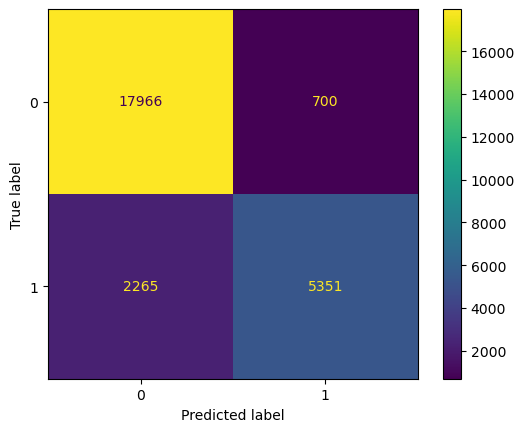

In [10]:
#show confusion matrix 


confusion_matrix = metrics.confusion_matrix(Y_test, test_classified)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()